# 000 Forecasting Bot

Starting from https://colab.research.google.com/drive/1_Il5h2Ed4zFa6Z3bROVCE68LZcSi4wHX?usp=sharing

## Leaderboard

### 10AUG24

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
df = pd.read_csv('leaderboard_20240810.csv')
rank = df.index.values
score = df['Total Spot Score'].values
take = df['Take'].values
plt.plot(rank, score/score.max(), label='score (normalized)')
plt.plot(rank, take/take.max(), color='green', label='take (normalized)')
plt.xlabel('Rank')
plt.ylabel('Metric')
plt.legend()
plt.xlim([1,50])
plt.title('AIQ3 Leaderboard as of 8/10/24');

In [ ]:
plt.hist(score, bins=30, density=True);

In [ ]:
df['Total Spot Score'].plot.hist(bins=50, density=True)
plt.title('PDF of scores')
plt.xlabel('Score')
plt.ylabel('Probability Density')
# Show the plot
plt.show()
df['Take'].plot.hist(bins=50, density=True)
plt.title('PDF of take')
plt.xlabel('Take')
plt.ylabel('Probability Density')
# Show the plot
plt.show()

In [ ]:
df_nonmf = df[df.Forecaster.apply(lambda x: 'mf-' not in x)]
top20_take = df_nonmf['Take'][df.Take > 2000]
top20_take.plot.hist(bins=50, density=True)
plt.title('PDF of top 20 take')
plt.xlabel('Take')
plt.ylabel('Probability Density')

## Imports

In [1]:
from IPython.display import Markdown
from omegaconf import OmegaConf
import datetime,json, os, requests, re
from openai import OpenAI
from tqdm import tqdm

## Today

In [2]:
import datetime
today = str(datetime.datetime.now())[0:10]
today

'2024-08-12'

## API Keys

In order to run this notebook as is, you'll need to enter a few API keys (use the key icon on the left to input them):

- `METACULUS_TOKEN`: you can find your Metaculus token under your bot's user settings page: https://www.metaculus.com/accounts/settings/, or on the bot registration page where you created the account: https://www.metaculus.com/aib/
- `OPENAPI_API_KEY`: get one from OpenAIs page: https://platform.openai.com/settings/profile?tab=api-keys
- `PERPLEXITY_API_KEY` - used to search up-to-date information about the question. Get one from https://www.perplexity.ai/settings/api
- `ASKNEWS_CLIENT_ID`, `ASKNEWS_SECRET`

In [3]:
token_fn = "tokens.yaml"

In [4]:
config = OmegaConf.load(token_fn)

def pr(tokens):
    print(OmegaConf.to_yaml(config))

## LLM and Metaculus Interaction

This section sets up some simple helper code you can use to get data about forecasting questions and to submit a prediction

In [5]:
AUTH_HEADERS = {"headers": {"Authorization": f"Token {config.METACULUS_TOKEN}"}}
API_BASE_URL = "https://www.metaculus.com/api2"
WARMUP_TOURNAMENT_ID = 3349
SUBMIT_PREDICTION = True

def find_number_before_percent(s):
    # Use a regular expression to find all numbers followed by a '%'
    matches = re.findall(r'(\d+)%', s)
    if matches:
        # Return the last number found before a '%'
        return int(matches[-1])
    else:
        # Return None if no number found
        return None

def post_question_comment(question_id, comment_text):
    """
    Post a comment on the question page as the bot user.
    """

    response = requests.post(
        f"{API_BASE_URL}/comments/",
        json={
            "comment_text": comment_text,
            "submit_type": "N",
            "include_latest_prediction": True,
            "question": question_id,
        },
        **AUTH_HEADERS,
    )
    response.raise_for_status()
    print("Comment posted for ", question_id)

def post_question_prediction(question_id, prediction_percentage):
    """
    Post a prediction value (between 1 and 100) on the question.
    """
    url = f"{API_BASE_URL}/questions/{question_id}/predict/"
    response = requests.post(
        url,
        json={"prediction": float(prediction_percentage) / 100},
        **AUTH_HEADERS,
    )
    response.raise_for_status()
    print("Prediction posted for ", question_id)


def get_question_details(question_id):
    """
    Get all details about a specific question.
    """
    url = f"{API_BASE_URL}/questions/{question_id}/"
    response = requests.get(
        url,
        **AUTH_HEADERS,
    )
    response.raise_for_status()
    return json.loads(response.content)

def list_questions(tournament_id=WARMUP_TOURNAMENT_ID, offset=0, count=1000):
    """
    List (all details) {count} questions from the {tournament_id}
    """
    url_qparams = {
        "limit": count,
        "offset": offset,
        "has_group": "false",
        "order_by": "-activity",
        "forecast_type": "binary",
        "project": tournament_id,
        "status": "open",
        "type": "forecast",
        "include_description": "true",
    }
    url = f"{API_BASE_URL}/questions/"
    response = requests.get(url, **AUTH_HEADERS, params=url_qparams)
    response.raise_for_status()
    data = json.loads(response.content)
    return data

## Forecast outliers

In [6]:
url_qparams = {
    "project": WARMUP_TOURNAMENT_ID,
    "type": "forecast",
    "include_description": "true",
    "limit": 1000,
}
url = f"{API_BASE_URL}/questions/"
response = requests.get(url, **AUTH_HEADERS, params=url_qparams)
response.raise_for_status()
data = json.loads(response.content)
len(data['results'])

100

In [7]:
questions = data['results']
excluded = [q for q in questions if q['resolution']==-2]
for q in excluded:
    print(q['id'], q['title'])

25852 PRACTICE: Will Donald Trump be elected to be US President in 2024?
25876 Will exactly 2 Starship launches reach reach an altitude of 160 kilometers by Sept 30, 2024?
25877 Will exactly 3 Starship launches reach reach an altitude of 160 kilometers by Sept 30, 2024?
25878 Will exactly 2 or 3 Starship launches reach reach an altitude of 160 kilometers by Sept 30, 2024?
25930 What will Trump's lead over Biden be greater than 2 and less than or equal to 3 on July 15, 2024, according to 538's national polling average?
25931 What will Trump's lead over Biden be greater than 3 and less than or equal to 4 on July 15, 2024, according to 538's national polling average?
25932 What will Trump's lead over Biden be greater than 2 and less than or equal to 4 on July 15, 2024, according to 538's national polling average?


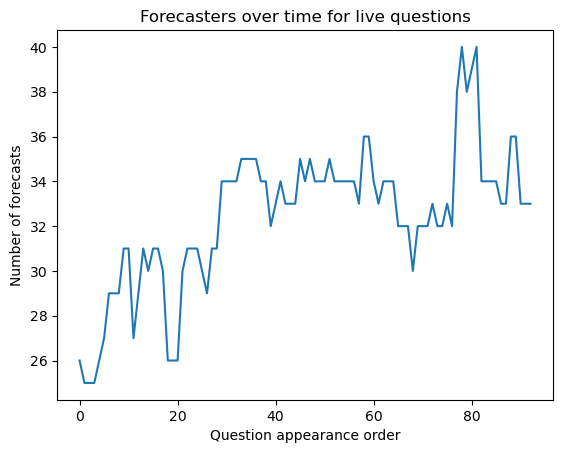

In [8]:
import matplotlib.pylab as plt
live = [q for q in questions if q['resolution']!=-2]
plt.plot([q['number_of_forecasters'] for q in live]);
plt.title('Forecasters over time for live questions')
plt.xlabel('Question appearance order')
plt.ylabel('Number of forecasts');

In [9]:
unresolved = [q for q in live if q['active_state']!='RESOLVED']

In [10]:
q = unresolved[0]
my_forecast = q['my_predictions']['predictions'][-1]['x']
my_forecast

0.7

In [11]:
for x in [x for x in q.keys() if 'prediction' in x]:
    print(x)
    print(q[x])

metaculus_prediction
{'full': 0.5024689125622709, 'history': [{'t': 1720450200.370142, 'x': 0.8337676266572321}, {'t': 1720451373.706415, 'x': 0.8187277404948885}, {'t': 1720451389.565865, 'x': 0.8187257091644053}, {'t': 1720451406.039746, 'x': 0.8187235981169729}, {'t': 1720451425.714539, 'x': 0.8187210753412929}, {'t': 1720451443.074749, 'x': 0.8187188496759453}, {'t': 1720451445.618497, 'x': 0.8187185219941754}, {'t': 1720451668.536768, 'x': 0.8025548559812409}, {'t': 1720451675.324353, 'x': 0.8025539422318363}, {'t': 1720451680.677244, 'x': 0.8025532208419889}, {'t': 1720451687.469944, 'x': 0.8025523033770009}, {'t': 1720451692.927313, 'x': 0.8025515665763562}, {'t': 1720451694.634206, 'x': 0.8025513351056854}, {'t': 1720454178.276012, 'x': 0.7230904489824356}, {'t': 1720458154.499796, 'x': 0.7161695686997194}, {'t': 1720458309.208368, 'x': 0.7476343917622305}, {'t': 1720459439.449585, 'x': 0.7780937770580579}, {'t': 1720460754.261539, 'x': 0.7270302779436294}, {'t': 1720464615.437

In [ ]:
q.keys()

In [ ]:
df = pd.DataFrame(q['metaculus_prediction']['history'])
df['t'] = pd.to_datetime(df['t'], unit='s')
df.plot(x='t', y='x')
plt.title(f'Metaculus prediction for {q["id"]}');

In [ ]:
q['community_prediction'].keys()

In [ ]:
q['community_prediction']['full']['q2']

In [ ]:
df = pd.DataFrame([(q['id'], q['title'], q['my_predictions']['predictions'][-1]['x'], q['community_prediction']['full']['q2']) for q in unresolved], columns=['id', 'title', 'bot', 'community'])

In [ ]:
df.plot.scatter(y='bot', x='community')
rho = df['bot'].corr(df['community'])
plt.title(f'My bot vs bot crowd: Correlation {int(100*rho)}%');

In [ ]:
import numpy as np
df = pd.DataFrame([(q['id'], q['title'], q['my_predictions']['predictions'][-1]['x'], q['community_prediction']['full']['q2']) for q in unresolved], columns=['id', 'title', 'bot', 'community'])
df['diff'] = np.abs(df.bot-df.community)
df = df.sort_values(by='diff',ascending=False).reset_index(drop=True)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 150)
df[df.index < 10]

In [ ]:
diff10 = df[df.index < 10]
diff10.plot.scatter(y='bot', x='community')
rho = diff10['bot'].corr(diff10['community'])
plt.title(f'My bot vs bot crowd on 10 top outliers: Correlation {int(100*rho)}%');

## IFP

In [12]:
class IFP:

    forecast_fields = ['question_id',
                       'title',
                       'feedback',
                       'resolution_criteria', 
                       'background', 
                       'event', 
                       'model_domain']

    forecast_format = f"|{'|'.join(forecast_fields)}|"

    openai_max_tokens = 30000

    def format(self):
        rec = vars(self)
        fmt = '|'.join([f"{x}: {rec[x]}" for x in self.forecast_fields])
        return '|' + fmt + '|'

    def over_openai_max(self):
        sep = self.format()
        return len(sep.split(' ')) > self.openai_max_tokens # Max limit for OpenAI

    def record(self):
        return self.format()
        if self.over_openai_max(): 
            self.news = ' '.join(self.news.split(' ')[0:int(0.5*self.openai_max_tokens)])
        if self.over_openai_max(): 
            self.research = ' '.join(self.research.split(' ')[0:int(0.5*self.openai_max_tokens)])
        if self.over_openai_max(): 
            raise Exception('IFP record over OpenAI max')
        return self.format()

    def __init__(self, question_id):
        self.question_id = question_id
        self.question_details = get_question_details(self.question_id)
        self.today = datetime.datetime.now().strftime("%Y-%m-%d")   
        self.title = self.question_details["title"]
        self.resolution_criteria = self.question_details["resolution_criteria"]
        self.background = self.question_details["description"]
        self.fine_print = self.question_details["fine_print"]
        self.event = ''
        self.model_domain = ''
        self.feedback = ''

    def report(self):
        rpt = f"""
The future event is described by this question: [ {self.title} ]
The resolution criteria are: [ {self.resolution_criteria} ]
The background is: [ {self.background} ]"""
        if self.fine_print:
            rpt += f"""
The fine print is: [ {self.fine_print} ]"""
        return rpt

    def upload(self):
        post_question_prediction(self.question_id, self.forecast)
        post_question_comment(self.question_id, self.rationale)

In [13]:
unit_test = False

In [14]:
if unit_test:
    qid = 26775
    ifp = IFP(qid)
    ifps = {qid: ifp}
    print(ifp.record())

## News source (AskNews)

https://colab.research.google.com/drive/1tc383HraMZOiyfKFF1EXAtlTYbsuv3Q5?usp=sharing

In [15]:
from asknews_sdk import AskNewsSDK

class AskNews():

    def __init__(self):
        ASKNEWS_CLIENT_ID = config.ASKNEWS_CLIENT_ID
        ASKNEWS_SECRET = config.ASKNEWS_SECRET
        
        self.ask = AskNewsSDK(
              client_id=config.ASKNEWS_CLIENT_ID,
              client_secret=config.ASKNEWS_SECRET,
              scopes=["news"]
          )

        self.cache = {}
        
    def query(self, 
              q, 
              method,    # use "nl" for natural language for your search, or "kw" for keyword, or 'both'
              strategy,
              return_type="dicts"): # strategy="latest news" enforces looking at the latest news only
                         # strategy="news knowledge" looks for relevant news within the past 60 days
        return self.ask.news.search_news(
            query=q, # your keyword query
            n_articles=10, # control the number of articles to include in the context
            return_type=return_type,  # you can also ask for "dicts" if you want more information
            method=method, 
            strategy=strategy).as_dicts # strategy="latest news" enforces looking at the latest news only,

    def multi_strategy(self, q, return_type="dicts"):
        all = []
        for strategy in ['latest news', 'news knowledge']:
            for x in self.query(q, 'both', strategy):
                all.append(x.summary if return_type=="dicts" else x)
        print("ALL")
        print(all[0])
        all = list(set(all))
        return '\n\n'.join(all)

    def research(self, group, return_type="dicts"):
        q = '\n'.join(ifp.title.strip() for ifp in group)
        try:
            return self.cache[q]
        except:
            news = self.multi_strategy(q,return_type)
            self.cache[q] = news
        return news

In [16]:
if unit_test:
    ask = AskNews()
    group = [IFP(id) for id in [26771, 26772, 26773, 26774]]
    news = ask.research(group)
    print(news)

## LLMs

### In general

In [19]:
class LLM:
    def __init__(self, system_role):
        self.system_role = system_role
        self.messages = [{"role": "system", "content": system_role}]
        self.cache = {}

    def chat(self, query):
        try:
            return self.cache[query]
        except:
            self.messages.append({"role": "user", "content": query})
            text = self.message()
            self.messages.append({"role": "assistant", "content": text})
            self.cache[query] = text
            return text

### MetaAI

https://pypi.org/project/meta-ai-api/1.0.6/

In [20]:
from meta_ai_api import MetaAI as mai

In [21]:
class MetaAI(LLM):

    def __init__(self, system_role = "Nice talker"):
        self.ai = mai()
        super().__init__(system_role)
        
    def message(self):
        self.response = self.ai.prompt(message=self.messages[-1]['content'])
        return self.response['message']

In [22]:
if unit_test:
    ai = MetaAI()
    r = ai.chat(ifp.title)
    print(r)

### HuggingChat

https://pypi.org/project/hugchat/

In [23]:
from hugchat import hugchat
from hugchat.login import Login

In [24]:
class HuggingChat(LLM):

    def __init__(self, system_role = "Nice talker"):
        # Log in to huggingface and grant authorization to huggingchat
        EMAIL = config.HUGGINGFACE_USERNAME
        PASSWD = config.HUGGINGFACE_PASSWORD
        cookie_path_dir = "./cookies/" # NOTE: trailing slash (/) is required to avoid errors
        sign = Login(EMAIL, PASSWD)
        cookies = sign.login(cookie_dir_path=cookie_path_dir, save_cookies=True)
        self.chatbot = hugchat.ChatBot(cookies=cookies.get_dict()) 
        super().__init__(system_role)
        
    def message(self):
        result = ''.join([x['token'] for x in self.chatbot.chat(self.system_role + '\n\n' + self.messages[-1]['content']) if x])
        return result

    def web_search(self, query):
        query_result = self.chatbot.query(query, web_search=True)
        return query_result
        print(query_result)
        for source in query_result.web_search_sources:
            print(source.link)
            print(source.title)
            print(source.hostname)

    def available_models(self):
        return [(i,str(x)) for i,x in enumerate(self.chatbot.get_available_llm_models())]

    def switch_llm(self, i):
        self.chatbot.switch_llm(i)

    def conversation_info(self):
        info = self.chatbot.get_conversation_info()
        # print(info.id, info.title, info.model, info.system_prompt, info.history)
        return info

In [25]:
if unit_test:
    hc = HuggingChat()
    hc.switch_llm(1)
    print(hc.chat(ifp.title))

### Metaculus Anthropic

In [26]:
import json

class Claude(LLM):
       
    def message(self):
        content = self.messages[-1]['content']
        url = "https://www.metaculus.com/proxy/anthropic/v1/messages"
        headers =  {"Authorization": f"Token {config.METACULUS_TOKEN}",
                    "anthropic-version": "2023-06-01",
                    "content-type": "application/json"}
        data = {"model": "claude-3-5-sonnet-20240620",
                "max_tokens": 1024,
                "messages": [{"role": "user", "content": self.system_role + '\n\n' + content}]}
        response = requests.post(url, headers=headers, data = json.dumps(data))
        # Check the response status code
        if response.status_code != 200:
            print("Request failed with status code", response.status_code)
            print(response.text)
        return response.json()['content'][0]['text']

In [27]:
if unit_test:
    claude = Claude('Please help me.')
    print(claude.chat(ifp.title))

### Perplexity

In [28]:
class Perplexity(LLM):
    def message(self):
        url = "https://api.perplexity.ai/chat/completions"
        headers = {
            "accept": "application/json",
            "authorization": f"Bearer {config.PERPLEXITY_API_KEY}",
            "content-type": "application/json"  }
        payload = {"model": config.PERPLEXITY_MODEL, "messages": self.messages }
        response = requests.post(url=url, json=payload, headers=headers)
        response.raise_for_status()
        return response.json()["choices"][0]["message"]["content"]

In [29]:
if unit_test:
    perp = Perplexity('You are the most deeply knowledgeable web search engine and insightful analyst')
    print(perp.chat(ifp.title))

### Metaculus OpenAI

In [30]:
import json

class MetacGPT(LLM):

    def __init__(self, system_role):
        super().__init__(system_role)
        
    def message(self):
        url = "https://www.metaculus.com/proxy/openai/v1/chat/completions"
        headers =  {"Authorization": f"Token {config.METACULUS_TOKEN}",
                    "content-type": "application/json"}
        data = {"model": "gpt-4o",
                "max_tokens": 1024,
                "messages": self.messages}
        response = requests.post(url, headers=headers, data = json.dumps(data))
        # Check the response status code
        if response.status_code != 200:
            print("Request failed with status code", response.status_code)
            print(response.text)
        self.rec = response.json()
        return self.rec ['choices'][0]['message']['content']

In [31]:
if unit_test:
    mgpt = MetacGPT('Please help me')
    print(mgpt.chat('Bruce Bueno de Mesquita'))

### OpenAI

In [32]:
class ChatGPT(LLM):
    def __init__(self, system_role):
        super().__init__(system_role)
        self.client = OpenAI(api_key=config.OPENAI_API_KEY)

    def message(self):
        chat_completion = self.client.chat.completions.create(
            model=config.OPENAI_MODEL,
            messages= self.messages)
        return chat_completion.choices[0].message.content

In [33]:
if unit_test:
    oai = ChatGPT('You are the most deeply knowledgeable web search engine and insightful analyst')
    print(oai.chat(ifp.title))

## Agents

#### Agent

In [34]:
class Agent:
    def __init__(self, system_role, llm):
        self.llm = llm(system_role)

    def chat(self, prompt):
        return self.llm.chat(prompt)

#### Question correlator for common topic inference

In [35]:
class QuestionRelator(Agent):
    def __init__(self, llm):
        self.system_role = f"""
You are prompted with list of forecasting questions, each with an id and a title.
Label each question with an underlying event.
If the questions are for the same event, use the same name for the underlying event.
Please return as separate lines formatted as |event|id|title|, do not add any other formatting.
"""
        super().__init__(self.system_role, llm)

    def relate(self, ifps):
        prompt = '\n'.join([f"{ifp.question_id}: {ifp.title}" for ifp in ifps.values()])
        KL = self.chat(prompt)
        print(KL)
        K1 = [x.split('|') for x in KL.split('\n')]
        self.topic_map = [(int(id),event) for _,event,id,_,_ in K1]
        self.topics = set([event for id,event in self.topic_map])
        self.topic_groups = {topic: [ifps[x] for x,y in self.topic_map if y == topic] for topic in self.topics}
        for id,event in self.topic_map :
            ifps[id].event = event
        return self.topic_groups

In [36]:
if unit_test:
    try:
        ifps
    except:
        test_day = '01AUG24'
        ifps = {id: IFP(id) for id in history[test_day]}
    qr = QuestionRelator(ChatGPT)
    print(qr.relate(ifps))

#### Model domain classifier

In [37]:
class ModelDomainClassifier(Agent):
    def __init__(self, llm):
        self.system_role = f"""
A question about an event is formatted as |id|question|criteria|background|fineprint|.
You will report the model domain of the question, one of

Rate over time
Weather prediction
State executive action
Election outcome
Geopolitics
Sports performance
Military conflict
Civil unrest
Dated product announcement
Market price
Macroeconomics
Epidemic
Disease
Drug discovery
Medical device
Crime
Leadership change
AI performance
Astronomy
Astrophysics
Other
"""
        super().__init__(self.system_role, llm)

    def classify(self, ifp):
        prompt = f"|{ifp.question_id}|{ifp.title}|{ifp.resolution_criteria}|{ifp.background}|{ifp.fine_print}|"
        self.R = self.chat(prompt)
        ifp.model_domain = self.R
        print(ifp.question_id, ifp.title)
        print(self.R)

In [38]:
if unit_test:
    mdc = ModelDomainClassifier(ChatGPT)
    for ifp in ifps.values():
        mdc.classify(ifp)

#### Rate Analyzer

In [39]:
class RateAnalyzer(Agent):
    def __init__(self, llm):
        self.system_role = f"""
A group of events are given, formatted as "GROUP" followed by a group of questions separated by carriage returns, followed by "NEWS" followed by news on the topic.
Today's date is {today}.
If the question is about a level that changes at some rate over time, you will report 
1. today's date, 
2. the end date of the question, 
3. the time in days D from today to end date, 
4. the daily rate of change R of the quantity,
5. today's value V of the quantity,
6. the change in value dV of the quantity = D * r,
7. the final value of the quantity F = V + dV.  Give your best estimate.
Otherwise if the question is about the date that an event will occur, you will report
1. today's date, 
2. the end (measurement) date of the question, 
3. the time in days D from today to end date, 
4. the specific date at which the event is most likely to occur, without reference to the end date of the question
5. whether the likely event date is before, or on or after the question end date

Provide only one type of answer, not both.
"""
        super().__init__(self.system_role, llm)

    def assess(self, group, news):
        titles = '\n'.join([ifp.title.strip() for ifp in group])
        self.q = f'GROUP\n{titles}\nNEWS\n{news}'
        self.rates = self.chat(self.q)
        return self.rates

In [40]:
if unit_test:
    try:
        group
    except:
        group = [IFP(id) for id in [26771, 26772, 26773, 26774]]

    rates = RateAnalyzer(ChatGPT)
    r = rates.assess(group, news)
    print(r)

#### Superforecaster

In [41]:
class Superforecaster(Agent):
    def __init__(self, llm):
        self.system_role = f"""
You are a superforecaster.  
You assign a probability to questions about events.
Questions are given as GROUP|group_description followed by NEWS|group_news followed by RATES|group_rates 
followed by the questions in the group formatted QUESTIONS followed by, for each question, {IFP.forecast_format}.
Questions which are about the same event should be assigned consistent probabilities.
Reply to questions with |ASSESSMENT|id|ZZ|rationale| where ZZ is an integer probability from 1 to 99 and rationale is your reasoning for the forecast.
Separate each question with '^^^'.
Do not add any additional headings or group labels or other formatting.
After your initial forecast you may receive feedback of form |CRITIC|id|feedback|.
Reply to each feedback with |id|ZZ|rationale| where ZZ is an integer probability from 1 to 99 and 
and rationale is a revised assessment which may be adjusted from a prior assessment due the feedback unless the feedback is "I concur".
"""
        super().__init__(self.system_role, llm)

    def forecast(self, event, news, rates, group):
        ifps = '\n'.join([ifp.record() for ifp in group])
        prompt = f"GROUP|{event}\nNEWS|{news}\nRATES|{rates}\nQUESTIONS\n{ifps}"
        self.F0 = self.chat(prompt)
        self.F1 = [x.strip().replace('\n', '') for x in self.F0.split('^^^')]
        self.F2 = [x.split('|') for x in self.F1] 
        self.F3 = [[x for x in y if x] for y in self.F2]
        self.F4 = [(int(id),int(forecast),rationale) for _, id, forecast, rationale in self.F3]
        self.ifps = {ifp.question_id: ifp for ifp in group}
        for id, forecast, rationale in self.F4:
            self.ifps[id].forecast = forecast
            self.ifps[id].rationale = rationale
            print(id, forecast, rationale)

    def reassess(self, ifp):
        prompt = f"|CRITIC|{ifp.question_id}|{ifp.feedback}|"
        self.R0 = self.chat(prompt)
        id,fcst,rationale = [x for x in self.R0.strip().split('|') if x]
        id = int(id)
        fcst = int(fcst)
        ifps[id].forecast = fcst
        ifps[id].rationale = rationale
        print(id, fcst, rationale)

In [42]:
if unit_test:
    sf = Superforecaster(ChatGPT)
    event = '2024 Grand Chess Tour'
    group = qr.topic_groups[event]
    sf.forecast(event, news, r, group)

#### Critic

In [43]:
class Critic (Agent):
    def __init__(self, llm):

        self.system_role = f"""
You a very smart and worldly person reviewing a superforecaster's assignment of probabilities to events.
You will receive an event with probabilities given as |event|id|question|zz|rationale|.
zz is an integer probability from 1 to 99 and rationale is the student's logic for assigning probability of zz.
You will reply with a line |id|feedback| where feedback is "I concur" if you see no problem with the rationale and zz otherwise presents possible problems with the rationale and zz.
"""
        super().__init__(self.system_role, llm)

    def feedback(self, ifp):
        self.fb = 'I prasldfkbeddy.'
        prompt = f"|{ifp.event}|{ifp.question_id}|{ifp.title}|{ifp.forecast}|{ifp.rationale}|"
        self.fb = self.chat(prompt)
        if '|' in self.fb: # LLM obeyed system role
            self.fb1 = self.fb.split('|')[2:]
            self.fb = ''.join([x.strip() for x in self.fb1 if x])
        ifp.feedback = self.fb 
        print(ifp.question_id, ifp.feedback)

In [44]:
if unit_test:
    for llm in [MetaAI, Claude, Perplexity, ChatGPT, HuggingChat]:
        print(llm.__name__)
        critic = Critic(llm)
        critic.feedback(ifp) 
        print()

#### Summarizer

Add an agent to summarize the back and forth between critic and forecaster into a single cogent rationale that incorporates all that was discussed.

## IFP history

In [47]:
history = { '08JUL24': [25876, 25877, 25875, 25873, 25871, 25878, 25874, 25872],
            '09JUL24': [26006, 25936, 25935, 25934, 25933, 26004, 26005],
            '10JUL24': [25955, 25956, 25957, 25960, 25959, 25954, 25953, 25952, 25958],
            '11JUL24': [26019, 26018, 26017, 26020, 26022, 26021, 26023, 26024],
            '12JUL24': [26095, 26096, 26097, 26098, 26099, 26100, 26101, 26102],
            '15JUL24': [26133, 26134, 26138, 26139, 26140, 26157, 26158, 26159],
            '16JUL24': [26189, 26190, 26191, 26192, 26193, 26194, 26195, 26196],
            '17JUL24': [26210, 26211, 26212, 26213, 26214, 26215, 26216],
            '18JUL24': [26232, 26233, 26234, 26235, 26236],
            '19JUL24': [26302, 26303, 26304, 26305, 26306, 26307],
            '22JUL24': [26387, 26388, 26389, 26390, 26391, 26392],
            '23JUL24': [26404, 26405, 26406, 26407, 26408],
            '24JUL24': [26550, 26551, 26552, 26553, 26554, 26555],
            '25JUL24': [26568, 26569, 26570, 26571, 26572, 26573, 26574, 26575, 26576, 26577],
            '26JUL24': [26638, 26639, 26640, 26641, 26642, 26643, 26644, 26645, 26646],
            '29JUL24': [26665, 26666, 26667, 26668, 26669, 26670, 26671, 26683],
            '30JUL24': [26700, 26701, 26702, 26703, 26704, 26705, 26706],
            '31JUL24': [26816, 26817, 26818, 26819, 26820, 26821, 26844],
            '01AUG24': [26771, 26772, 26773, 26774, 26775, 26776, 26777, 26778, 26779, 26780, 26781],
            '02AUG24': [26837, 26838, 26839, 26840, 26841, 26842],
            '05AUG24': [26913, 26914, 26915, 26916, 26917, 26918, 26919, 26920],
            '06AUG24': [26957, 27019, 27020, 27021, 27022],
            '07AUG24': [26958, 26959, 27017, 27018],
            '08AUG24': [26975, 26976, 26977, 26978, 26979, 26980, 26981, 26982, 26983, 26984, 26985, 26986, 27039],
            '09AUG24': [27085, 27086, 27087, 27088, 27089],
            '10AUG24': [27132, 27133, 27134, 27135, 27136]}

In [46]:
ifps = list_questions()['results']
today_ids = list(sorted([x['id'] for x in ifps]))
print(today, today_ids)

2024-08-12 [27132, 27133, 27134, 27135, 27136]


In [48]:
ifps = {id: IFP(id) for id in today_ids}

## Forecasting process

In [49]:
class Forecaster:
    
    def __init__(self, ifps):
        self.max_tries = 4
        self.qr = QuestionRelator(MetacGPT)
        self.ask = AskNews()
        self.mdc = ModelDomainClassifier(MetacGPT)
        self.ifps = ifps
        
    def fit(self):
        print('MODEL DOMAIN')
        for ifp in self.ifps.values():
            self.mdc.classify(ifp)
        print()  
        print('CORRELATOR')
        self.rho = self.qr.relate(self.ifps)
        print('FORECASTER')
        for event, group in self.rho.items():
            print('FORECASTING EVENT', event)
            self.news = self.ask.research(group)   
            print('NEWS')
            print(self.news)
            self.ra = RateAnalyzer(Claude)
            self.rates = self.ra.assess(group, self.news)
            print('RATES', self.rates)
            self.sf = Superforecaster(MetacGPT)
            self.sf.forecast(event, self.news, self.rates, group)
            critic = Critic(MetacGPT)
            for ifp in group:
                print("REFINING", ifp.question_id)
                for i in range(self.max_tries):
                    print("Pass", i, "of", self.max_tries, "on", ifp.question_id)
                    if 'concur' in ifp.feedback:
                        print("concur 1")
                        break
                    critic.feedback(ifp)
                    if 'concur' in ifp.feedback:
                        print("concur 2")
                        break
                    self.sf.reassess(ifp)
                print("===============================================")

    def report(self):
        for ifp in self.ifps.values():
            print(ifp.question_id, ifp.title)
            print("Forecast", ifp.forecast)
            print("Rationale", ifp.rationale, '\n')

    def upload(self):
        for ifp in self.ifps.values():
            ifp.upload()

In [ ]:
if unit_test:
    test_day = '01AUG24'
    ifps = {id: IFP(id) for id in history[test_day]}

## Outlier reforecast

## Daily forecast

In [50]:
fcst = Forecaster(ifps)

In [51]:
fcst.fit()

MODEL DOMAIN
27132 Will Iran carry out a deadly attack within Israel before October 1, 2024?
Military conflict
27133 Will Donald Trump debate the Democratic nominee for president more than once before October 1, 2024?
Election outcome
27134 Will the S&P 500 index go up in September 2024?
Market price
27135 Before October 1, 2024, will Tech Crunch report new layoffs at Google or Alphabet?
Market price
27136 Will Robert F. Kennedy Jr. suspend his 2024 presidential campaign before September 24, 2024?
Election outcome

CORRELATOR
|Iran-Israel conflict|27132|Will Iran carry out a deadly attack within Israel before October 1, 2024?|
|2024 U.S. Presidential Election|27133|Will Donald Trump debate the Democratic nominee for president more than once before October 1, 2024?|
|S&P 500 performance|27134|Will the S&P 500 index go up in September 2024?|
|Google/Alphabet Layoffs|27135|Before October 1, 2024, will Tech Crunch report new layoffs at Google or Alphabet?|
|2024 U.S. Presidential Election|

In [52]:
fcst.report()

27132 Will Iran carry out a deadly attack within Israel before October 1, 2024?
Forecast 70
Rationale Given the intelligence reports indicating a high likelihood of an imminent Iranian attack, the increased military readiness of both Israel and Iran, the deployment of additional US military assets to the region, and credible reports citing specific dates of potential attacks around August 13, there is a significant probability that Iran will carry out a deadly attack within Israel before October 1, 2024. However, considering the complexities and the possibility that diplomatic efforts might prevent the attack, I assign a 70% probability. 

27133 Will Donald Trump debate the Democratic nominee for president more than once before October 1, 2024?
Forecast 65
Rationale Acknowledging the inherent uncertainties in the political climate, including the potential for last-minute cancellations or changes in candidates' positions, it is prudent to assign a slightly lower probability. The likelih

In [53]:
fcst.upload()

Prediction posted for  27132
Comment posted for  27132
Prediction posted for  27133
Comment posted for  27133
Prediction posted for  27134
Comment posted for  27134
Prediction posted for  27135
Comment posted for  27135
Prediction posted for  27136
Comment posted for  27136
